In [51]:
###Import des packages
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy

In [11]:
instants = np.linspace(start=-5, stop=5, num=4, endpoint=True)

In [3]:
def generation(n, alpha=1.7, beta=0.9, gamma=10, delta=10):
    # Initialize samples array with zeros
    sample = np.zeros(n)
    
    # Constants that do not depend on the sample index and thus can be computed once
    if alpha != 1:
        S_alpha_beta = (1 + beta ** 2 * np.tan(np.pi * alpha / 2) ** 2) ** (1 / (2 * alpha))
        B_alpha_beta = (1 / alpha) * np.arctan(beta * np.tan(np.pi * alpha / 2))

    for i in range(n):
        U = np.random.uniform(-np.pi/2, np.pi/2)
        W = -np.log(1 - np.random.uniform(0,1))
        
        # Handle the case alpha = 1 separately
        if alpha != 1:
            part1 = np.sin(alpha * (U + B_alpha_beta)) / (np.cos(U) ** (1 / alpha))
            part2 = (np.cos(U - alpha * (U + B_alpha_beta)) / W) ** ((1 - alpha) / alpha)
            sample[i] = S_alpha_beta * part1 * part2
        else:
            sample[i] = (2 / np.pi) * ((np.pi / 2 + beta * U) * np.tan(U) - beta * np.log((np.pi / 2 * W * np.cos(U))/(np.pi+beta*U)))

    # Apply scaling and location shifting
    sample = gamma * sample + delta
    return sample

In [102]:
default = generation(n=1000)

In [4]:
def char_fun_zolo(t, nu, etha, tau):
    """characteristic function to use from S2 to S5

    Parameters
    ----------------------------
    t : float
    the "instant" we want to check

    nu : float
    parameter of the alpha-stable distribution, >= 1/4.

    etha :float
    parameter of the alpha-stable distribution, np.sign(etha) <= min(1, 2*np.sqrt(nu)-1)

    tau : float
    parameter of the alpha-stable distribution, absolute value < inf
    ------------------------------
    """

    y = -np.exp((nu**(-1/2))*(np.log(np.abs(t)) + tau - 1j*(np.pi/2)*etha*np.sign(t)) + np.e*((nu**(-1/2))-1))
    return y
    

In [5]:
def emp_char_fun(sample, t):
    """function to evaluate the empirical characteristic of a function at an instant t

    Parameters
    -------------------------
    sample : array-like
    sample on which we want to evaluate the characteristic function

    t : int, float
    moment to estimate/generate
    --------------------------
    """
    expo_transfo = np.exp(-sample*1j*t)
    empirical = np.mean(expo_transfo)
    return empirical
    

In [93]:
def th_char_fun(t, alpha=1.7, beta=0.9, gamma=10, delta=10):
    """characteristic function used in the paper

    Parameters
    --------------------------------
    t : float, array-like
    value or values for which we would like to compute the characteristic function, instants/moments

    alpha, beta, gamma, delta : float
    the parameters of our distribution
    ---------------------------------
    """
    if alpha == 1:
        y=np.exp(1j*delta*t-gamma*np.abs(t)*(1+1j*beta*(2/np.pi)*np.sign(t)*np.log(gamma*np.abs(t))))
    else :
        y=np.exp(1j*delta*t-gamma*np.abs(t)*(1+1j*beta*np.tan(np.pi*alpha/2)*np.sign(t)*((np.abs(gamma*t)**(1-alpha))-1)))

    return y

In [29]:
def gaussian_ker(u=0, y=0, epsilon=1):
    """gaussian kernel for weights
    
    Parameters
    -------------------
    y : float, or array-like
    the point we have, the output

    u : float, or array-like
    the point from which we want to calculate a weight

    epsilon : int, float
    the scale parameter for which we want to compute the kernel
    ----------
    """

    w = (1/np.sqrt(2*np.pi*(epsilon**2)))*np.exp(-(np.abs((u-y)))**2/(2*(epsilon**2)))
    return w

$\theta = (\alpha, \beta, \gamma, \delta)$ 

N = 1000

$x^1,...,x^p$ ~ $\pi(x|\theta)$

### So, we generate X and observe Y (that we also generated but we know the parameters)

$\pi_{LF}(\theta|y)$ = $\pi(\theta)\mathbb{E}_{\pi(x|\theta)}[K_{\epsilon} (y-x)]$ $\leftarrow$ we do monte carlo on this

$K_{\epsilon} (y-x)$ def by $S(y)$ ~ $N(S(x), \epsilon^2 \hat{\Sigma})$ $\leftarrow$ that would be our gaussian kernel, so we just draw $x_1,..., x_p$ ~ $\pi(x|\hat{\theta})$ then compute S(x), after that, estimate the cov(S(x)|$\hat{\theta}$) and then S(y) according to the previous distrib

$\hat{\Sigma}$ is an estimate of $Cov(S(x)\hat{\theta})$

$\Lambda$ = diag(0.25, 0.25, 1, 1)

Mutation kernel : $M_t(\theta_t) = \sum_{i=1}^{N} W_{t-1}^{(i)}(\theta_{t-1}^{(i)}) \phi(\theta_t ; \theta_{t-1}^{(i)})$

Gaussian kernel : $L(x,t) = \sum_{n = -M}^{M}f(x-n)G(n,t)$

with G(n,t) = $\frac{1}{\sqrt{2\pi t}}e^{-\frac{n^2}{2t}}$


As t increases, $\epsilon_t$ decreases

$\hat{c_t}$ is the 90th quantile of the weights

# For the rest we need to use : 

# $\alpha = 1.7$
# $\beta = 0.9$
# $\gamma = 10$
# $\delta = 10$

In [7]:
{}

{}

# Seed : 256652

In [8]:
np.random.seed(256652)

#creation des prior des parametres cf section 3.1

prior_alpha = np.random.uniform(1.1, 2., size=1000)
prior_beta = np.random.uniform(-1., 1, size=1000)
prior_gamma = np.random.uniform(0., 300., size=1000)
prior_delta = np.random.uniform(-300., 300., size=1000)

#scale parameters

#epsilon_t

mille = np.linspace(start=100, stop=1000, endpoint=True, num=10)[::-1]
cent = np.linspace(start=10, stop=100, endpoint=False, num=90)[::-1]
dix = np.linspace(start=5, stop=10, endpoint=False, num=10)[::-1]
cinq = np.linspace(start=3, stop=5, endpoint=False, num=40)[::-1]
trois = np.linspace(start=0, stop=3, endpoint=False, num=300)
trois = np.delete(arr=trois, obj=0)
trois = trois[::-1]

scale_param = np.concatenate((mille, cent, dix, cinq, trois))


N = 1000
varcov_lambda = np.array([0.25,0.,0.,0.,0.,0.25, 0., 0.,0.,0.,1.,0.,0.,0.,0.,1]).reshape([4,4])

In [143]:
def pi_lf(epsilon_t, sample=default, N=1000, alpha=1.7, beta=0.9, gamma=10, delta=10, possession=False):
    """function to have the likelihood free density given in the article

    Parameters
    -----------------
    N : int
    number of priors we want to generate
        
    alpha, beta, gamma, delta : int, float
    the parameters with which we want to compute the true data if we don't already have it


    sample : array-like
    the data we observe

    summary_statistic : array-like
    summary statistic used to make tests on the distance between two datasets

    epsilon_t : int, float
    scale parameter, determines 

    Possession : boolean
    by default, set to false, to determine if we want to generate the data or if we already have it

    method : str
    the method with which we would compute the summary statistics
    -------------------
    """
    if possession == False :
        data = generation(n=1000, alpha=alpha, beta=beta, gamma=gamma, delta=delta)
    else :
        data = sample
    #set the priors like in the paper
    prior_alpha = np.random.uniform(1.1, 2., size=N)
    prior_beta = np.random.uniform(-1., 1, size=N)
    prior_gamma = np.random.uniform(0., 30., size=N)
    prior_delta = np.random.uniform(-30., 30., size=N)
    prior_gen = np.vstack((prior_alpha,prior_beta,prior_gamma, prior_delta))
    prior_gen = np.transpose(prior_gen)

    true_param = zolotarev_transfo(sample=data, xi=0.15)
    proposed_param = np.zeros(4)
    for i in range(N):
        proposed_data = generation(n=10000, alpha=prior_gen[i,0], beta=prior_gen[i,1],
                                  gamma=prior_gen[i,2], delta=prior_gen[i,3])
        interm = zolotarev_transfo(sample=proposed_data, xi=0.15)
        proposed_param = np.vstack((proposed_param, interm))

    proposed_param = np.delete(arr=proposed_param, obj=0, axis=0)      
    diff = np.zeros(4)   
    for i in range(N):
        interm = proposed_param[i]-true_param
        diff = np.vstack((diff, interm))
    diff = np.delete(arr=diff, obj=0, axis=0)
    kernel_applied = gaussian_ker(u=diff, y=0, epsilon=epsilon_t)
    pi_lf_output = prior_gen*kernel_applied
    
    return pi_lf_output
    
    
    #maybe correction : keep an everage per theta created, so the expectation is thus just the smoothing kernel applied 
    #to the summary statistic
    #and maybe create another function instead of just one big with the computation of the summary statistic
    
    
    


    #centering and scaling for the case of empirical characteristic function
    true_param = np.zeros(4, dtype=complex)
    estimated_param_gen = np.zeros(4, dtype=complex)
    data = (data-np.median(data))/(np.quantile(a=data, q=0.75)-np.quantile(a=data, q=0.25))
    #getting the summary statistic in the case of the empirical characteristic function
    for i in range(N):
        proposed_data = generation(n=1000, alpha=prior_alpha[i], beta=prior_beta[i], gamma=prior_gamma[i], delta=prior_delta[i])
        proposed_data = (proposed_data-np.median(proposed_data))/(np.quantile(a=proposed_data, q=0.75)-np.quantile(a=proposed_data, q=0.25))
        estimated_param = np.zeros(4, dtype=complex)
        for i in range(4):
            estimated_param[i] = emp_char_fun(sample=proposed_data, t=instants[i])
        estimated_param_gen = np.vstack((estimated_param, estimated_param_gen))
    #we obtain many summary statistics that depend on the theta and the draws generated
    for i in range(4):
        true_param[i] = emp_char_fun(sample=data, t=instants[i])

    #we now have both the summary statistics of the data we generated and the data that we 'observed'

    #we delete the first row because we created it just to be able to stack the ones 
    #we generated after that
    estimated_param_gen = np.delete(arr=estimated_param_gen, obj=0, axis=0)

    #we now compute S(y) - S(x) as a random variable because it is on that one that we will 
    #approximate the excpectation by 'the smoothed kernel' mean


In [70]:
test_3 = generation(n=1000, alpha=2, beta=0, gamma=10, delta=0)

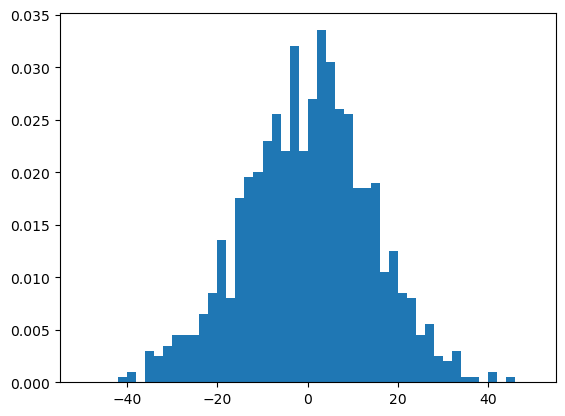

In [71]:
plt.hist(test_3, bins=50, density=True, range=(-50, 50))
plt.show()

In [144]:
exec_1 = pi_lf(N=1000, epsilon_t=0.1)

In [145]:
test_alpha = np.mean(exec_1[:,0])
test_beta = np.mean(exec_1[:,1])
test_gamma = np.mean(exec_1[:,2])
test_delta = np.mean(exec_1[:,3])

print('alpha :', test_alpha, '\n', 'beta :', test_beta, '\n',
      'gamma :', test_gamma, '\n', 'delta :', test_delta)

alpha : 1.2849477021175195 
 beta : -0.08223599696012873 
 gamma : 2.360524443277173 
 delta : 0.0933877329548266


In [114]:
test_alpha = np.mean(exec_1[:,0])
test_beta = np.mean(exec_1[:,1])
test_gamma = np.mean(exec_1[:,2])
test_delta = np.mean(exec_1[:,3])

print('alpha :', test_alpha, '\n', 'beta :', test_beta, '\n',
      'gamma :', test_gamma, '\n', 'delta :', test_delta)

alpha : 13.785378083046501 
 beta : 0.1729232563781362 
 gamma : 8.726267423104412 
 delta : 3.9082419870958183


In [74]:
for i in range(1000):
    if exec_1[i,2]<0:
        print(i)

0
4
8
10
11
13
15
17
20
22
24
26
27
28
29
30
32
33
34
36
39
41
44
45
46
47
48
50
51
53
57
58
60
63
65
66
67
71
72
73
75
76
77
79
80
82
83
85
86
88
90
91
92
94
95
97
98
99
100
101
104
105
108
112
115
117
118
119
120
122
124
125
126
127
128
130
132
133
135
137
145
147
150
151
154
156
157
158
159
160
161
162
164
165
166
167
168
169
171
172
175
176
178
179
180
181
182
183
185
188
192
195
197
199
200
201
202
203
204
206
208
209
213
214
215
216
217
218
220
224
227
228
230
231
232
233
235
237
238
239
241
242
244
247
249
251
256
261
262
264
265
266
268
269
270
271
273
274
275
277
279
280
281
282
283
287
288
289
290
291
292
295
296
298
299
303
304
305
308
309
315
317
318
320
321
322
323
325
327
329
330
331
332
341
342
343
344
347
348
349
350
351
352
354
358
359
362
364
365
367
368
369
373
374
376
377
378
382
383
384
385
387
388
393
394
396
398
399
401
403
405
406
410
411
412
416
419
423
426
427
432
436
441
443
444
445
447
449
451
455
456
457
460
461
462
466
467
469
472
476
480
483
484
486
490
4

In [118]:
a = np.array((1,1,1))
b = np.array((2,2,2))
c = np.array((3,3,3))
tot = np.vstack((a,b,c))
test_12 = np.delete(arr=tot, obj=1, axis=0)
print(tot, '\n', '\n', test_12)

[[1 1 1]
 [2 2 2]
 [3 3 3]] 
 
 [[1 1 1]
 [3 3 3]]


In [19]:
test_12.shape[1]

3

In [15]:
for i in range(3):
    print(tot[i] - a)

[0 0 0]
[1 1 1]
[2 2 2]


In [132]:
gaussian_ker(u=tot*0.0001, epsilon=1)

array([[0.39894228, 0.39894228, 0.39894228],
       [0.39894227, 0.39894227, 0.39894227],
       [0.39894226, 0.39894226, 0.39894226]])

In [123]:
tre = np.array((1,1,1,1))
bre = np.array((2,2,2,2))
hor = np.vstack((bre, tre))
vert = np.transpose(hor)

In [125]:
hor

array([[2, 2, 2, 2],
       [1, 1, 1, 1]])

In [126]:
vert

array([[2, 1],
       [2, 1],
       [2, 1],
       [2, 1]])

In [9]:
def mc_culloch_q(data, gamma=1):
    """fonction pour calculer les quantiles de mc_culloch utilises dans le papier

    Parameters
    --------------
    data : array
    les donnes pour lesquelles on veut calculer les quantiles

    gamma : float
    valeur 1 par defaut, d'apres le papier, on utilise le gamma utilise pour faire les simulations
    ----------------
    """
    data_sorted = np.sort(data)
    useful_quantiles = np.quantile(a=data_sorted, q=[0.95, 0.75, 0.5, 0.25, 0.05])
    q_95 = useful_quantiles[0]
    q_75 = useful_quantiles[1]
    q_50 = useful_quantiles[2]
    q_25 = useful_quantiles[3]
    q_05 = useful_quantiles[4]
    alpha_hat = (q_95-q_05)/(q_75-q_25)
    beta_hat = (q_95+q_05+2*q_50)/(q_95-q_05)
    gamma_hat = (q_75-q_25)/gamma
    #on a le gamma au denominateur parce que c'est comme ca qu on a genere nos donnees
    #d'apres le papier, ca va de prendre le gamma qu'on a utililse pour generer
    delta_hat = np.mean(data_simulation)
    S_1 = np.transpose(np.array((alpha_hat, beta_hat, gamma_hat, delta_hat)))
    return S_1

In [76]:
def zolotarev_transfo(sample, xi):
    """function to use for the estimation based on the zolotarev transformation

    Parameters
    --------------------------
    Sample : array-like
    Sample to do the transformation on

    xi : int, float
    The constant used in the transformation
    --------------------------
    """
    if xi<=0 or xi>1/2 :
        raise ValueError('Xi must be between 0 and 1/2')
    taille = len(sample)
    Z = []
    for i in range(int(taille/3)):
        transfo = sample[3*i-2] - xi*sample[3*i-1] - (1 - xi)*sample[3*i]
        Z.append(transfo)
    V = []
    U = []
    for i in range(len(Z)):
        V.append(np.log(np.abs(Z[i])))
        U.append(np.sign(sample[i]))
    V = np.array(V)
    U = np.array(U)
    S_U_squared = (np.std(U))**2
    S_V_squared = (np.std(V))**2
    nu_tilde = (6/(np.pi)**2)*S_V_squared - (3/2)*S_U_squared + 1
    etha_hat = np.mean(U)
    tau_hat = np.mean(V)
    nu_hat = 0
    if nu_tilde > ((1+np.abs(etha_hat))**2)/4:
        nu_hat = nu_tilde
    else:
        nu_hat = ((1+np.abs(etha_hat))**2)/4
    delta_hat = np.mean(sample)
    S_2 = np.array((nu_hat, etha_hat, tau_hat, delta_hat))
    return S_2

In [77]:
def u_hat(x, t):
    """function to use to calculate presss moments

    Parameters
    ---------------
    x : array-like

    the data

    t : int, float
    the real number we want to know the image by the function
    ---------------
    """

    y = np.arctan(np.sum(np.cos(t*x))/np.sum(np.sin(t*x)))
    return y

In [78]:
test_u = np.array((np.pi, np.pi, np.pi, np.pi))

In [79]:
u_hat(x=test_u,t=1/4)

0.7853981633974484

In [80]:
u_hat(x=test_u, t=1/2)

6.123233995736766e-17

In [81]:
#derniere ligne confirme que c est bien 0, on tombe bien sur arctan(0) (aux approximations pres)

In [82]:
#fonction u_hat marche bien, on retombe sur arctan de 1

In [95]:
def presss_moments(sample, alpha=1.7, beta=0, gamma=10, delta=10,
                   t_1=0.2, t_2=0.8, t_3=0.1, t_4=0.4):
    """function to calculate press's moments

    Parameters
    ----------------

    sample : array-like
    the data

    alpha, beta, gamma, delta : int, float
    parameters we used to simulate the data (?)

    t_1 : int, float
    t_2 : int, float
    t_3 : int, float
    t_4 : int, float
    moments we want to evaluate, the default parameters are given by Koutrouvelis (1980)
    ---------------
    """
    
    #estimation of characteristic function at different moments
    transfo_1 = th_char_fun(t=t_1, beta=beta)
    transfo_2 = th_char_fun(t=t_2, beta=beta)
    transfo_3 = th_char_fun(t=t_3, beta=beta)
    transfo_4 = th_char_fun(t=t_4, beta=beta)
    log_gamma_hat_top = (np.log(np.abs(t_1))*np.log(-np.log(np.abs(transfo_2)))-np.log(np.abs(t_2))*np.log(-np.log(np.abs(transfo_1))))
    log_gamma_hat = log_gamma_hat_top/np.log(np.abs(t_1/t_2))
    alpha_hat = np.log(np.log(np.abs(transfo_1))/np.log(np.abs(transfo_2)))/np.log(np.abs(t_1/t_2))
    beta_hat_top = ((u_hat(x=sample, t=t_4)/t_4)-(u_hat(x=sample, t=t_3)/t_3))
    beta_hat_bot = ((np.abs(t_4)**(alpha_hat-1))-(np.abs(t_3)**(alpha_hat-1)))*((np.exp(log_gamma_hat))**alpha_hat)*np.tan((alpha_hat*np.pi)/2)
    beta_hat = beta_hat_top/beta_hat_bot
    delta_hat_top = (((np.abs(t_4))**(alpha_hat-1))*u_hat(x=sample, t=t_3)/t_3)-((((np.abs(t_3))**(alpha_hat-1))*u_hat(x=sample,t=t_4))/t_4)
    delta_hat_bot = (np.abs(t_4)**(alpha_hat-1)) - (np.abs(t_3)**(alpha_hat-1))
    delta_hat = delta_hat_top/delta_hat_bot
    y = np.array((alpha_hat, beta_hat, np.exp(log_gamma_hat), delta_hat))
    return y


    

In [96]:
test = generation(n=1000, alpha=2, beta=0, gamma=5, delta=0)
S_hat = zolotarev_transfo(test, xi=0.15)
print(S_hat)

[0.25150376 0.003003   1.64572324 0.04843054]


In [97]:
#ca converge tres tres lentement

In [98]:
presss_moments(sample=test)

array([1.00000000e+00, 1.40189052e+00, 1.00000000e+01, 3.66165695e+16])

In [21]:
initial = np.zeros(4)
for i in range(250):
    test_2 = generation(n=1000, alpha=1.7, beta=0.9, gamma=10, delta=10)
    initial = np.vstack((initial, presss_moments(sample=test_2)))
    

resultat = np.zeros(4)
resultat[0] = np.mean(initial[:,0])
resultat[1] = np.mean(initial[:,1])
resultat[2] = np.mean(initial[:,2])
resultat[3] = np.mean(initial[:,3])
    

In [22]:
print(resultat)

[ 0.10902846  2.14843924  3.81087938 -4.70566537]


# Press
$\hat{\alpha}$ et $\hat{\delta}$ assez bons

Assez bof : $\hat{\gamma}$

Catastrophe : $\hat{\beta}$

# Le résultat précédent c'est quand on prenait un truc un peu au pif
# Quand on utilise leurs valeurs de $\alpha, \beta, \gamma, \delta$ en fait c'est pas mal
En fait c'est pas foufou...

In [23]:
np.zeros(4)


array([0., 0., 0., 0.])

In [24]:
%%capture
#data generation and definition of moments

data_simulation = generation(n=1000, alpha=2, beta=0.5, gamma=3, delta=4)

In [25]:
%%capture
#sort data to be sure the quantiles are well computed bc you never know
data_simulation = np.sort(data_simulation)

In [26]:
useful_quantiles = np.quantile(a=data_simulation, q=[0.95, 0.75, 0.5, 0.25, 0.05])

In [27]:
useful_quantiles

array([10.9038422 ,  6.76197407,  4.07913098,  1.04915232, -3.26879304])

In [28]:
q_95 = useful_quantiles[0]
q_75 = useful_quantiles[1]
q_50 = useful_quantiles[2]
q_25 = useful_quantiles[3]
q_05 = useful_quantiles[4]

### Mc Culloch's quantiles

In [29]:
alpha_hat = (q_95-q_05)/(q_75-q_25)
beta_hat = (q_95+q_05+2*q_50)/(q_95-q_05)
gamma_hat = (q_75-q_25)/3
#on a le 3 au denominateur parce que c'est comme ca qu on a genere nos donnees
#d'apres le papier, ca va de prendre le gamma qu'on a utililse pour generer
delta_hat = np.mean(data_simulation)

In [30]:
S_1 = np.transpose(np.array((alpha_hat, beta_hat, gamma_hat, delta_hat)))

In [31]:
S_1

array([2.48084675, 1.11435247, 1.90427392, 3.99770943])

In [32]:
delta_hat

3.997709434703393

Test runned with one million simulations, the estimators seemed to be biased.

def prior_lf_mc():
    "estimation monte carlo de la vraisemblance
    

def smc_prc_abc(N=1000, epsilon_t):
    """Algorithme ABC de l'appendix A de l'article.


    Parameters
    ---------------------------
    N : int
    Nombre d'echantillons crees pour les parametres

    epsilon_t : array
    Les marges d'acceptation pour l'algorithme
    """
    #les prior sont des uniformes cf partie 3.1
    prior_alpha = np.random.uniform(1.1, 2., size=N)
    prior_beta = np.random.uniform(-1., 1, size=N)
    prior_gamma = np.random.uniform(0., 300., size=N)
    prior_delta = np.random.uniform(-300., 300., size=N)
    prior_gen = np.vstack((prior_alpha,prior_beta,prior_delta, prior_gamma))
    
    #the weights
    

    

    

In [33]:
a = np.array((1,2,3,4,5))

In [34]:
a

array([1, 2, 3, 4, 5])

In [35]:
b = np.array((5,4,3,2,1))

In [36]:
a/b

array([0.2, 0.5, 1. , 2. , 5. ])

In [37]:
c = np.array((5,1,3,2,4))

In [38]:
test = np.vstack((a,b,c))

In [39]:
test

array([[1, 2, 3, 4, 5],
       [5, 4, 3, 2, 1],
       [5, 1, 3, 2, 4]])

In [40]:
test = np.hstack((a,b,c))

In [41]:
test

array([1, 2, 3, 4, 5, 5, 4, 3, 2, 1, 5, 1, 3, 2, 4])

In [42]:
np.linalg.norm(a - b)

6.324555320336759

In [43]:
test[0,:]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
zebulon = generation(n=1000)

In [44]:
def emp_cdf(sample,t):
    """a function made to calculate the empirical cumulative distribution function

    Parameters
    ------------------
    sample : array-like
    data, generated or observed

    t : int, float
    the argument in which we want to evaluate the empirical cdf
    ------------------
    """
    result = 0
    sorted_sample = np.sort(sample)
    for i in sorted_sample:
        if i<=t:
            result += 1/len(sample)
    return result

In [45]:
def kolmogorov_smirnov(sample,proposal,q_1=0.25,q_2=0.75):
    """a function to get the S_5 statistic from the article

    Parameters
    ---------------
    sample : array-like
    the observed data about which we want to see if we are close or not 

    proposal : array-like
    the proposal X, simulated from parameters, to see if it fits

    q_1,q_2 : float
    must be between 0 and 1, values to give to have a certain quantile in the summary statistics
    ---------------
    """
    if (0<q_1<1 and 0<q_2<1) == False :
        raise ValueError('q_1 and q_2 must be between 0 and 1')
    KS = 0
    z = np.linspace(start=-400, stop=400, num=100000)
    for i in z:
        interm = np.abs(emp_cdf(sample,i)-emp_cdf(proposal,i))
        if interm>KS:
            KS=interm
    quantiles = np.quantile(a=proposal, q=[q_1, q_2])
    mean_sample = np.mean(proposal)
    return np.array((mean_sample, quantiles[0], quantiles[1], KS))
    

In [46]:
true_one = generation(n=10000)
proposition_1 = generation(n=10000, alpha=2, beta=1, delta=8, gamma=5)
print(kolmogorov_smirnov(sample=true_one, proposal=proposition_1), '\n',
      kolmogorov_smirnov(sample=true_one, proposal=true_one))

[ 8.12431735  3.4034849  12.79301466  0.1762    ] 
 [ 9.91443119 -1.98034826 17.59056193  0.        ]


In [66]:
true_value = []
proposal = []

for i in instants:
    true_value.append(emp_char_fun(sample=true_one, t=i))
    proposal.append(emp_char_fun(sample=proposition_1, t=i))

true_value = np.array(true_value)
proposal = np.array(proposal)

In [67]:
true_value.shape

(10,)

In [68]:
np.linalg.norm(true_value-proposal)

0.05599945965953793

In [73]:
def accept_reject_abc(N=1000, epsilon_t=0.5, alpha=2, beta=0, gamma=1, delta=0, method='emp_char'):
    """algorithme d'acceptation rejet 'basique', vu en cours

    Parameters
    ---------------------------------
    N : int
    nombre de simulations faites

    epsilon_t : array
    scale parameters, marge d'acceptation

    alpha, beta, gamma, delta :
    parametres pour les simulations

    method : str
    le type de methode que l on veut utiliser, par methode on entend quel type de 'summary statistique' on veut utiliser
    -------------------------------
    """
    data = generation(n=N, alpha=alpha, beta=beta, gamma=gamma, delta=delta)
    #priors
    prior_alpha = np.random.uniform(1.1, 2., size=N)
    prior_beta = np.random.uniform(-1., 1, size=N)
    prior_gamma = np.random.uniform(0., 300., size=N)
    prior_delta = np.random.uniform(-300., 300., size=N)
    prior_gen = np.vstack((prior_alpha,prior_beta,prior_delta, prior_gamma))

    if method == 'emp_char':
        true_data_estim = np.zeros(shape=10, dtype=complex)
        for i in range(20):
            true_data_estim[i] = emp_char_fun(sample=data, t=instants[i])
    elif method == 'zolotarev':
        true_data_estim = zolotarev_transfo(sample=data, xi=0.15)
    elif method == 'press':
        true_data_estim = presss_moments(sample=data)

    alpha_test = 0
    beta_test = 0
    gamma_test = 0
    delta_test = 0
    for i in range(N):
        proposed_data = generation(n=N, alpha=prior_gen[:,i][0],
                                   beta=prior_gen[:,i][1],
                                   delta=prior_gen[:,i][2],
                                   gamma=prior_gen[:,i][3])
        alpha_test = prior_gen[:,i][0]
        beta_test = prior_gen[:,i][1]
        gamma_test = prior_gen[:,i][2]
        delta_test = prior_gen[:,i][3]
        estimated = np.zeros(shape=10, dtype=complex)
        for i in range(20):
            estimated[i] = emp_char_fun(sample=proposed_data, t=instants[i])
        if np.linalg.norm(estimated-true_data_estim) < epsilon_t:
            return np.array((alpha_test, beta_test, gamma_test, delta_test))
            
        else :
            continue

In [74]:
test_1 = accept_reject_abc(N=200, epsilon_t=0.3)

In [75]:
start = time.time()
test_1
end = time.time()
print(test_1, end - start)

None 0.00012111663818359375


In [ ]:
#avec une si petite distance ca ne marchait pas

In [ ]:
start = time.time()
liste_parametres = np.zeros(4)
for i in range(len(scale_param)):
    pouet = accept_reject_abc(N=200, epsilon_t=scale_param[-i])
    if pouet != None
        liste_parametres = np.vstack((pouet,liste_parametres))

end = time.time()

print(end - start)

In [ ]:
#must change the parameters, N must be 200, too long otherwise

In [ ]:
%%capture
liste_parametres

In [ ]:
#not working very well, new distance needed

In [ ]:
#Works probably, pb : wrong use of mc culloch quantiles, need to invert --> pb , how

In [ ]:
liste_parametres

In [ ]:
type(None)

In [ ]:
total = np.zeros(4)
for i in range(len(liste_parametres)):
    if type(liste_parametres[i][1]) != None:
        interm = np.array(liste_parametres[i][1])
        print(interm)
        total = np.vstack((total, interm))

In [ ]:
if 1 == 2:
    print('no')
else:
    print('yes')

In [ ]:
liste_parametres[3][1]

In [ ]:
for i in range(len(liste_parametres)):
    if liste_parametres[i][0] == 4.85:
        print(np.array(liste_parametres[i][1]))

In [ ]:
#faudra changer aussi le format du test, pas liste mais passer direct en array

In [ ]:
a

In [ ]:
b

In [ ]:
np.linalg.norm(a-b)

In [ ]:
np.sqrt(40)